# Scalable Vertex Recognition

#### imports

In [479]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go

#### input

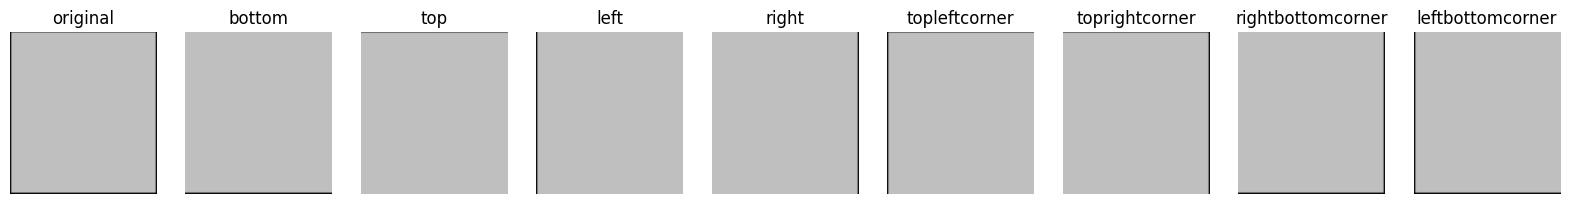

In [480]:
activate_plotly = False # turn expensive renderings on and off

# Define the paths
target_image_path = 'images/testcase3.png' # version 2 for paper with scaled vertex
device_template_path = 'images/device.png'
subtask_template_path = 'images/subtask.png'

target_img = cv2.imread(target_image_path)
device_template= cv2.imread(device_template_path)
subtask_template = cv2.imread(subtask_template_path)

device_template = cv2.resize(device_template, (180, 200))
subtask_template = cv2.resize(subtask_template, (80, 80))

# device_template = device_template[5:-5, 5:-5]
# Generate five different templates

templates = {
    'original': device_template,
    'bottom': cv2.resize(device_template[5:, 5:-5], (180, 200)),
    'top': cv2.resize(device_template[:-5, 5:-5], (180, 200)),
    'left': cv2.resize(device_template[5:-5, :-5], (180, 200)),
    'right': cv2.resize(device_template[5:-5, 5:], (180, 200)),
    'topleftcorner': cv2.resize(device_template[:-5, :-5], (180, 200)),
    'toprightcorner': cv2.resize(device_template[:-5, 5:], (180, 200)),
    'rightbottomcorner': cv2.resize(device_template[5:, 5:], (180, 200)),
    'leftbottomcorner': cv2.resize(device_template[5:, :-5], (180, 200))
}

original_image = target_img.copy()
# Draw all five templates next to each other
fig, axes = plt.subplots(1, 9, figsize=(20, 10))
for ax, (key, template) in zip(axes, templates.items()):
    ax.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
    ax.set_title(key)
    ax.axis('off')
plt.show()

#### finding subtasks first and drawing a grey box over them for further processing

subtask 1 at: (1809, 460)
subtask 2 at: (269, 610)
subtask 3 at: (269, 750)
subtask 4 at: (1289, 750)
subtask 5 at: (269, 880)
subtask 6 at: (1289, 880)
subtask 7 at: (819, 890)


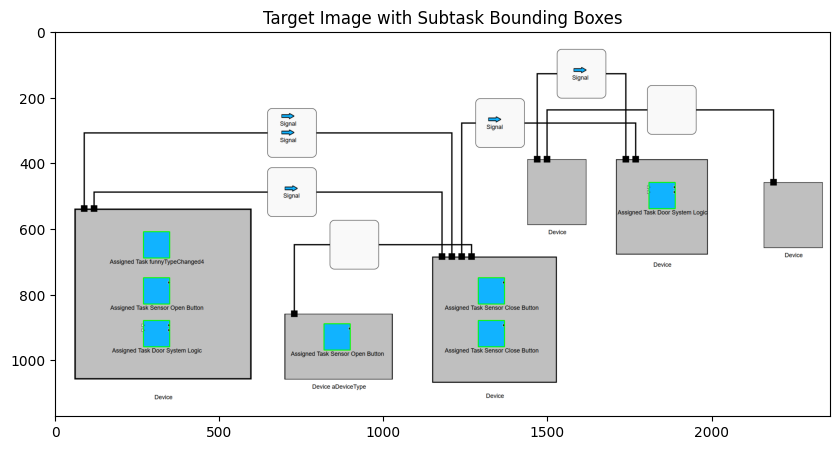

In [481]:
res = cv2.matchTemplate(target_img, subtask_template, cv2.TM_CCOEFF_NORMED)
# Threshold the result
threshold = 0.8
loc = np.where(res >= threshold)

subtasks = [(int(pt[0]), int(pt[1])) for pt in zip(*loc[::-1])]
# Draw grey boxes over the subtasks, 10 pixels bigger in every direction
for pt in subtasks:
    top_left = (pt[0] - 10, pt[1] - 10)
    bottom_right = (pt[0] + subtask_template.shape[1] + 10, pt[1] + subtask_template.shape[0] + 10)
    cv2.rectangle(target_img, top_left, bottom_right, (191, 191, 191), -1)
for i, pt in enumerate(zip(*loc[::-1])):
    print(f"subtask {i+1} at: ({int(pt[0])}, {int(pt[1])})")

# Draw the bounding boxes for the subtask templates
target_img_with_subtask_boxes = original_image.copy()
for pt in zip(*loc[::-1]):
    bottom_right = (pt[0] + subtask_template.shape[1], pt[1] + subtask_template.shape[0])
    cv2.rectangle(target_img_with_subtask_boxes, pt, bottom_right, (0, 255, 0), 2)

# Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(target_img_with_subtask_boxes, cv2.COLOR_BGR2RGB))
plt.title('Target Image with Subtask Bounding Boxes')
plt.show()

## Template Matching

Use opencv template matching: https://docs.opencv.org/4.10.0/df/dfb/group__imgproc__object.html

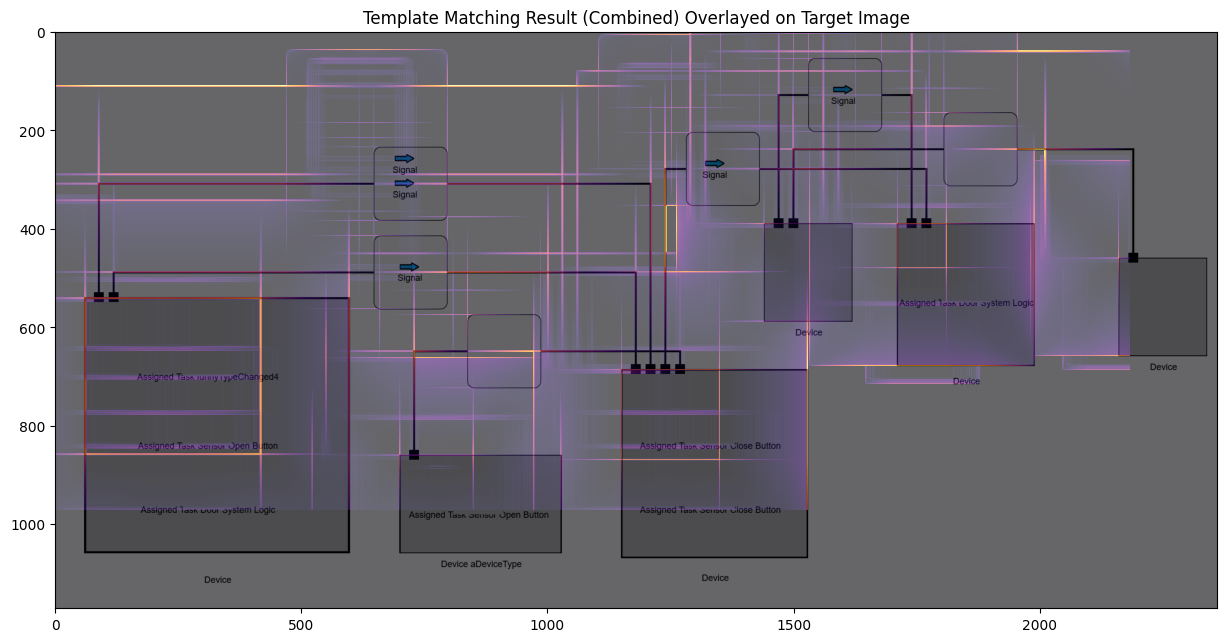

In [482]:
# Initialize the result matrix with zeros
res = np.zeros(target_img.shape[:2], dtype=np.float32)

# Perform template matching for each template and combine the results
for key, template in templates.items():
    temp_res = cv2.matchTemplate(target_img, template, cv2.TM_CCOEFF_NORMED)
    
    # Pad the result to match the size of the target image
    pad_height = target_img.shape[0] - temp_res.shape[0]
    pad_width = target_img.shape[1] - temp_res.shape[1]
    temp_res_padded = np.pad(temp_res, ((0, pad_height), (0, pad_width)), 'constant', constant_values=0)
    
    res = np.maximum(res, temp_res_padded)

# Overlay the result matrix on the original image
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
plt.imshow(res, cmap='inferno', alpha=0.6, interpolation='nearest', vmin=0, vmax=1)  # `alpha` controls the transparency.
plt.title('Template Matching Result (Combined) Overlayed on Target Image')
plt.show()

# Threshold the result
threshold = 0.6
loc = np.where(res >= threshold)

## Visualization after Thresholding

### Analysis After Thresholding

In [483]:
# Set all values below the threshold to 0
thresholded_res = np.copy(res)
thresholded_res[thresholded_res < threshold] = 0

### 2D on Target Image

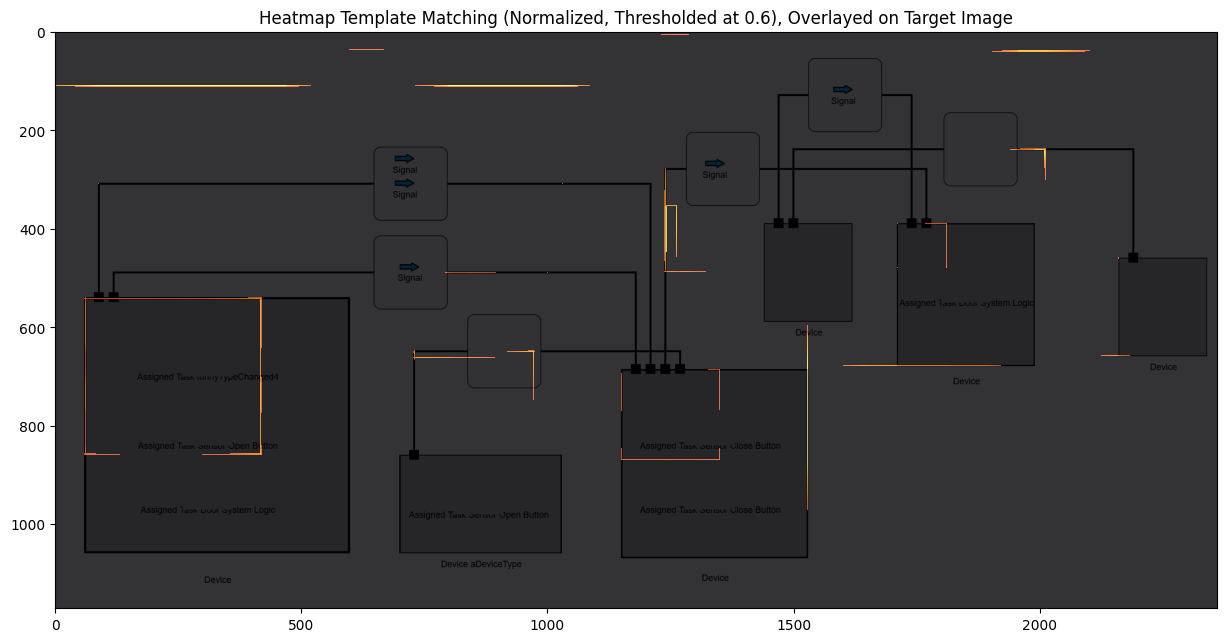

In [484]:
# Overlay the heatmap on the original image
plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
plt.imshow(thresholded_res, cmap='inferno', alpha=0.8, interpolation='nearest', vmin=0, vmax=1)  # `alpha` controls the transparency.
plt.title(f'Heatmap Template Matching (Normalized, Thresholded at {threshold}), Overlayed on Target Image')
plt.show()


## From Pixels to Boxes

### Threshold to get Foreground
Original target image is thresholded to get foreground. This is used to restrict matches to the foreground. TODO: is this still a thing?

In [489]:
# Convert to grayscale
target_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

# Threshold the image
_, target_thresh = cv2.threshold(target_gray, 245, 255, cv2.THRESH_BINARY_INV)

### Visualize Foreground

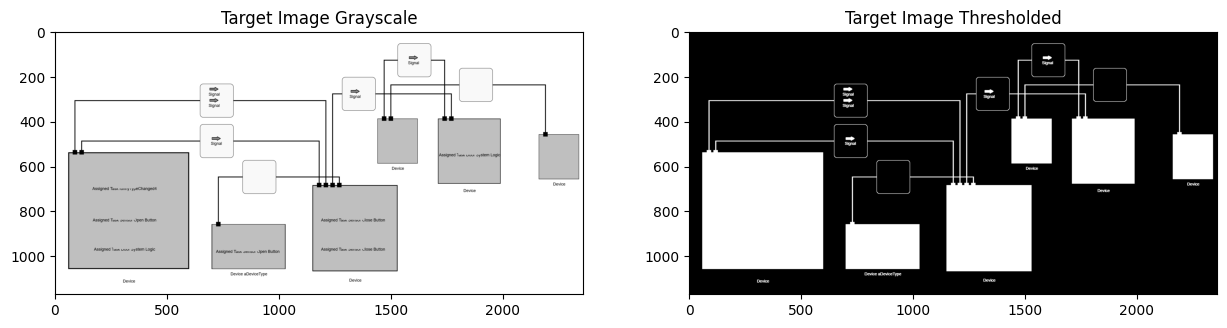

In [490]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(target_gray, cmap='gray')
ax[0].set_title('Target Image Grayscale')
ax[1].imshow(target_thresh, cmap='gray')
ax[1].set_title('Target Image Thresholded')
plt.show()

### Filter Foreground
Filters the bounding boxes of the vertices. Only locations in the foreground are kept. This is probably obsolete. 

In [491]:
loc_foreground = []
for pt in zip(*loc[::-1]):
    if np.all(target_thresh[pt[1]:pt[1] + device_template.shape[0], pt[0]:pt[0] + device_template.shape[1]] == 255):
        loc_foreground.append(pt)

### Visualize Bounding Boxes after Foreground Filtering

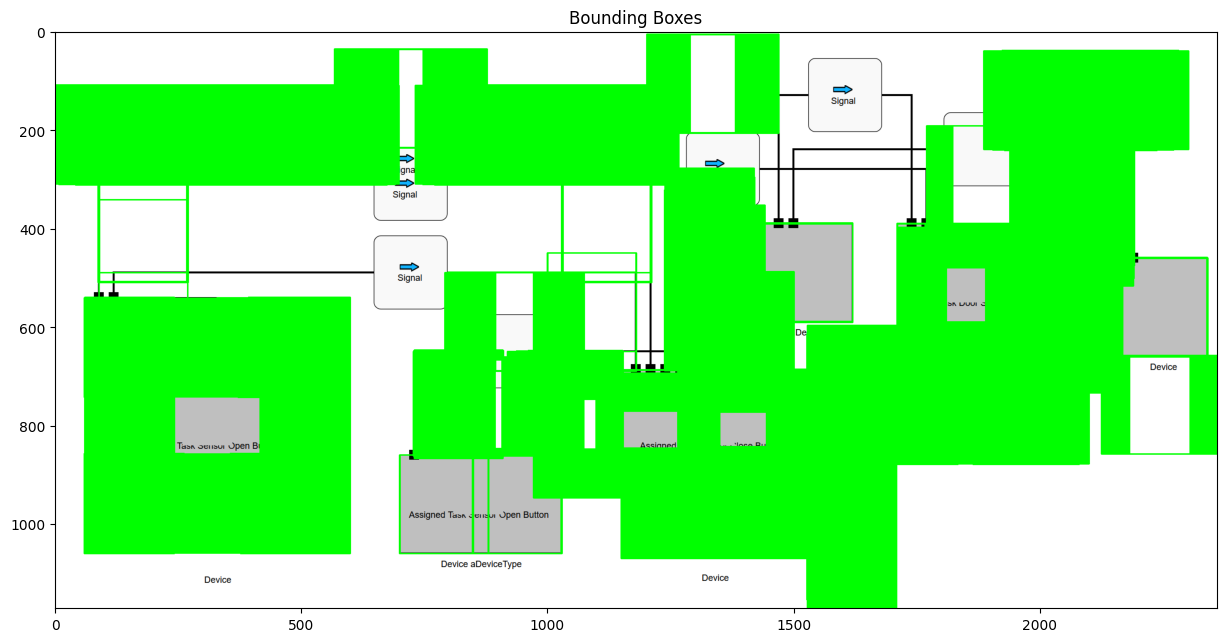

In [492]:
target_img_bounding_boxes = target_img.copy()
for pt in zip(*loc[::-1]):
    cv2.rectangle(target_img_bounding_boxes, pt, (pt[0] + device_template.shape[1], pt[1] + device_template.shape[0]), (0, 255, 0), 2)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(cv2.cvtColor(target_img_bounding_boxes, cv2.COLOR_BGR2RGB))
ax.set_title('Bounding Boxes')
plt.show()

### Analyse Foreground Check
Foregound check has currently negligible effect and could be deactivated.

In [493]:
# Compare loc and loc_foreground
print(f"Found {len(loc[0])} matches with a threshold of {threshold}")
print(f"Found {len(loc_foreground)} matches with a threshold of {threshold} and foreground filter")

Found 12537 matches with a threshold of 0.6
Found 4022 matches with a threshold of 0.6 and foreground filter


#### ... on Target Image

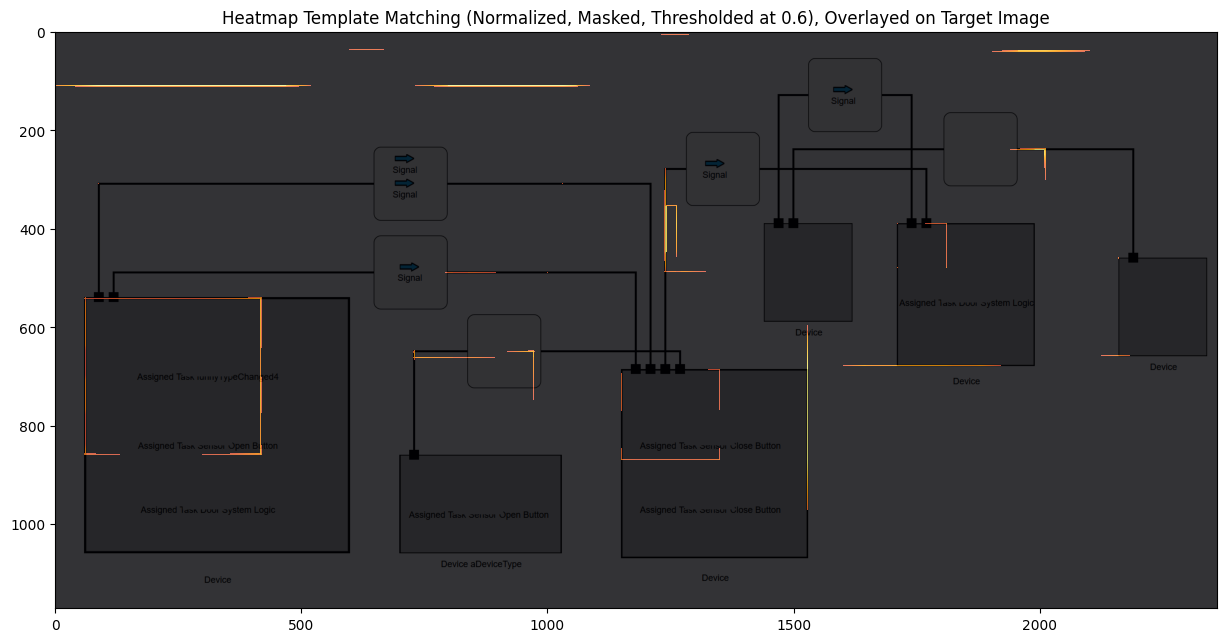

In [495]:
# Overlay the heatmap on the original image
plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
plt.imshow(thresholded_res, cmap='inferno', alpha=0.8, interpolation='nearest', vmin=0, vmax=1)  # `alpha` controls the transparency.
plt.title(f'Heatmap Template Matching (Normalized, Masked, Thresholded at {threshold}), Overlayed on Target Image')
plt.show()

Idea. To distinguish between differently coloured boxes do comparison above the threshold which coloured box gets the most points. Old idea. It is easier if it finds every box with confidence. 

### Fill bounding boxes
Fills the bounding boxes of the vertices

In [496]:
matched_templates_bbox_filled = np.zeros(target_img.shape[:2], dtype=np.uint8)
for pt in loc_foreground:
    cv2.rectangle(matched_templates_bbox_filled, pt, (pt[0] + device_template.shape[1], pt[1] + device_template.shape[0]), 255, -1)

#### Plot filled bounding boxes

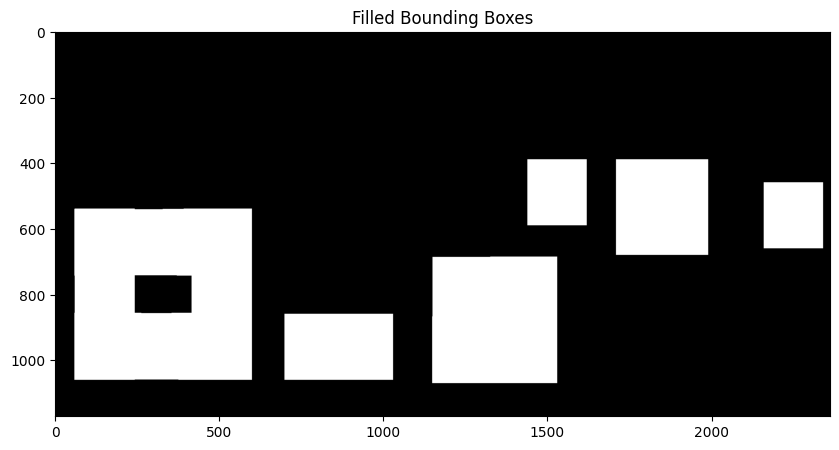

In [497]:
# Draw the filled bounding boxes
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(matched_templates_bbox_filled, cmap='gray')
ax.set_title('Filled Bounding Boxes')
plt.show()

### Find Contours in the super boxes
The overlapping bounding boxes are now puzzled together to big boxes

In [498]:
target_img_boundings_grouped = target_img.copy()

# Find contours
contours, _ = cv2.findContours(matched_templates_bbox_filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Store the bounding boxes of the vertices
bounding_boxes = []

# Draw bounding boxes based on contours and save their coordinates
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(target_img_boundings_grouped, (x, y), (x+w, y+h), (0, 255, 0), 4)
    bounding_boxes.append((x, y, w, h))
print(f"bounding_boxes: {bounding_boxes}")

bounding_boxes: [(699, 860, 331, 201), (1149, 686, 381, 385), (59, 540, 541, 521), (2159, 460, 181, 201), (1709, 390, 281, 291), (1439, 390, 181, 201)]


#### Visualize the super boxes

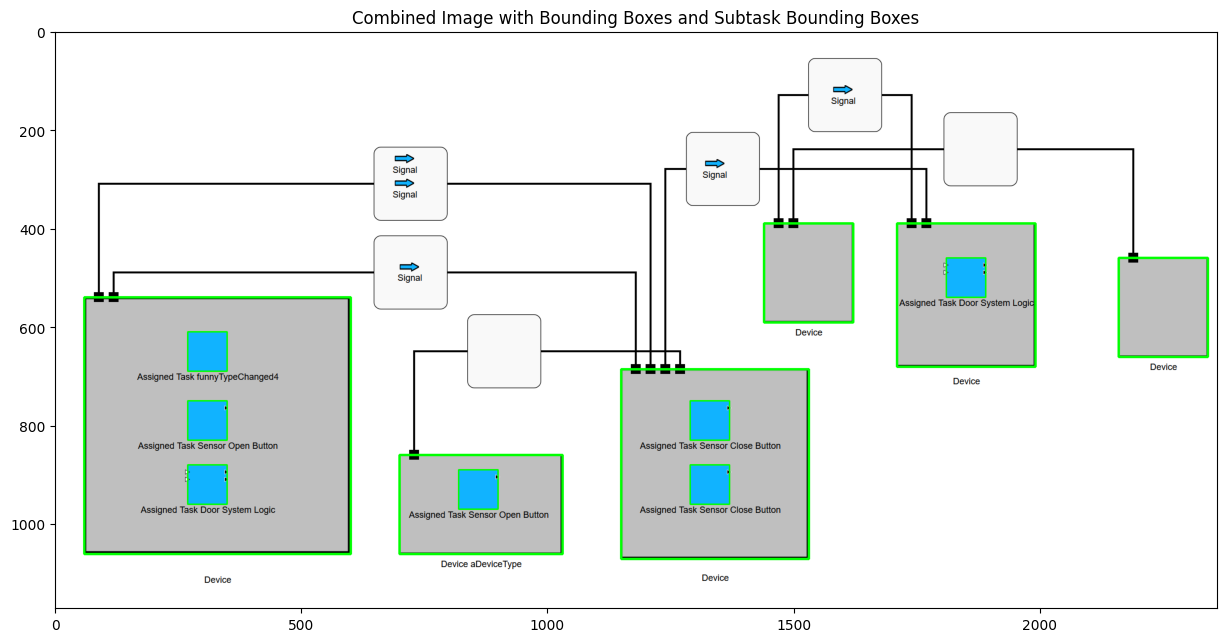

In [499]:
# Draw the result
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Overlay the bounding boxes detected templates on the initial target image with subtask bounding boxes
combined_image = target_img_with_subtask_boxes.copy()
for (x, y, w, h) in bounding_boxes:
    cv2.rectangle(combined_image, (x, y), (x+w, y+h), (0, 255, 0), 4)

ax.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
ax.set_title("Combined Image with Bounding Boxes and Subtask Bounding Boxes")

plt.show()